In [1]:
# remember to put this line in your notebook, otherwise the visualization won't show up
%pylab inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas

from sklearn import preprocessing
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.5f}'.format

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Descriptive Congressional Data
citylab_data = pd.read_csv('./data/citylab_cdi_extended.csv', float_precision='round_trip')
citylab_data.drop(columns=['Cluster'], inplace=True) #Removing 'Cluster', not ours
print(len(citylab_data), "records"); citylab_data.head()

435 records


,CD,Very low density,Low density,Medium density,High density,Pre-2018 incumbent,Pre-2018 party,2018 winner party,Clinton16,Trump16,Obama12,Romney12,Obama08,McCain08,cong_R16,cong_D16,cong_Other16,PVI,Pure rural,Rural-suburban mix,Sparse suburban,Dense suburban,Urban-suburban mix,Pure urban
0,AK-AL,0.48299,0.19833,0.22925,0.08943,Don Young,R,R,0.37600,0.52800,0.41200,0.55300,0.38100,0.59700,0.50321,0.36022,0.13657,9,0.42453,0.36823,0.08579,0.06039,0.04274,0.01832
1,AL-01,0.36536,0.42888,0.19741,0.00835,Bradley Byrne,R,R,0.34100,0.63500,0.37400,0.61800,0.38500,0.60900,0.96382,0.00000,0.03618,15,0.05286,0.87889,0.04258,0.01370,0.00834,0.00362
2,AL-02,0.53549,0.31615,0.14837,0.00000,Martha Roby,R,R,0.33000,0.64900,0.36400,0.62900,0.35000,0.64500,0.48769,0.40526,0.10705,16,0.84647,0.11375,0.01845,0.01024,0.00740,0.00371
3,AL-03,0.54041,0.38935,0.06555,0.00469,Mike Rogers,R,R,0.32300,0.65300,0.36800,0.62300,0.36600,0.62600,0.66932,0.32932,0.00136,16,0.74623,0.17631,0.03582,0.01890,0.01473,0.00801
4,AL-04,0.69533,0.28894,0.01573,0.00000,Robert Aderholt,R,R,0.17400,0.80400,0.24000,0.74800,0.25500,0.73300,0.98530,0.00000,0.01470,30,0.80989,0.10235,0.03396,0.02260,0.01930,0.01190


In [3]:
#Representative Party Affiliation Counts from 2010-2018, 
party_counts = pd.read_csv('./data/cd_111_116_party_counts.csv').sort_values(by=['CD'])
party_counts.reset_index(inplace=True, drop=True)
print(len(party_counts), "records"); party_counts.head()

453 records


,CD,Democratic,Republican,Other,Total
0,AK-AL,0,9,0,9
1,AL-01,0,8,0,8
2,AL-02,1,8,0,9
3,AL-03,0,9,0,9
4,AL-04,0,9,0,9


In [4]:
#Aggregated Grant Fund Data at the Congressional District Label per Year 
funding_totals = pd.read_csv('./data/fedReporter_sum.csv',)
print(len(funding_totals), "records"); funding_totals.head()

3629 records


,CONGRESSIONAL_DISTRICT,ORGANIZATION_STATE,DEPARTMENT,AGENCY,FY,FY_TOTAL_COST,CD
0,0,AK,NSF,NSF,2010,51603573.00000,AK-AL
1,0,AS,NSF,NSF,2010,25504.00000,AS-AL
2,0,CA,NSF,NSF,2010,1733993.00000,CA-AL
3,0,CO,NSF,NSF,2010,19500.00000,CO-AL
4,0,CT,NSF,NSF,2010,2547090.00000,CT-AL


Now we have to prepare/combine our data 

In [5]:
#We'll simplify some of the congressional density index categories to 3, down from 6
citylab_data['Rural'] = citylab_data['Pure rural'] + citylab_data['Rural-suburban mix']
citylab_data['Suburban'] = citylab_data['Sparse suburban'] + citylab_data['Dense suburban']
citylab_data['Urban'] = citylab_data['Urban-suburban mix'] + citylab_data['Pure urban']

In [6]:
#Change party counts to a percentage
party_counts['Republican'] = party_counts['Republican'] / party_counts['Total']
party_counts['Democratic'] = party_counts['Democratic'] / party_counts['Total']
party_counts['Other'] = party_counts['Other'] / party_counts['Total']

In [7]:
#Quick check of how much money couldn't be mapped to a congressional district
funds_unmatched = (funding_totals[~funding_totals["CD"].isin(citylab_data['CD'].unique())]['FY_TOTAL_COST'].sum())
funds_matched   = (funding_totals[funding_totals["CD"].isin(citylab_data['CD'].unique())]['FY_TOTAL_COST'].sum())
print("Total NSF Funding: {:,}".format(funds_unmatched + funds_matched))
print("Matched NSF Funding: {:,}, {:.2%}".format(funds_matched, funds_matched/(funds_unmatched + funds_matched)))
print("Unmatched NSF Funding: {:,}, {:.2%}".format(funds_unmatched, funds_unmatched/(funds_unmatched + funds_matched)))

# Filter out unknown congressional districts
matched_records = funding_totals[funding_totals["CD"].isin(citylab_data['CD'].unique())]

Total NSF Funding: 35,392,455,628.0
Matched NSF Funding: 33,370,191,917.0, 94.29%
Unmatched NSF Funding: 2,022,263,711.0, 5.71%


In [8]:
#Lets pivot the funding data to make each fiscal year a column 
nsf_funding = pd.pivot_table(matched_records[['CD', 'FY','FY_TOTAL_COST']], values = 'FY_TOTAL_COST', index=['CD'], 
                             columns = 'FY').reset_index()
nsf_funding.fillna(0, inplace=True)

print("CDs with NSF Funding: ",len(nsf_funding))
nsf_funding.head()

CDs with NSF Funding:  434


FY,CD,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,AK-AL,51603573.00000,22687709.00000,22539453.00000,18967382.00000,20995436.00000,13296918.00000,14825962.00000,25180562.00000,28372191.00000
1,AL-01,1491436.00000,2094388.00000,812058.00000,2951772.00000,2258434.00000,2580521.00000,1620257.00000,2424339.00000,2815529.00000
2,AL-02,191663.00000,698822.00000,1664756.00000,0.00000,1564887.00000,737822.00000,475136.00000,2286960.00000,1124906.00000
3,AL-03,11416358.00000,17828995.00000,5335738.00000,8842962.00000,7510531.00000,5526549.00000,16313640.00000,13572790.00000,14050883.00000
4,AL-04,1713314.00000,0.00000,0.00000,1037202.00000,179999.00000,795529.00000,0.00000,0.00000,0.00000


In [9]:
# We need to normalize our nsf funding data to perform our clustering
# Leeave CD column out of this process
nsf_funding_norm = preprocessing.normalize(nsf_funding.iloc[:,1:])

In [10]:
# Create a PCA instance
pca = PCA(n_components=9)
principalComponents = pca.fit_transform(nsf_funding_norm)

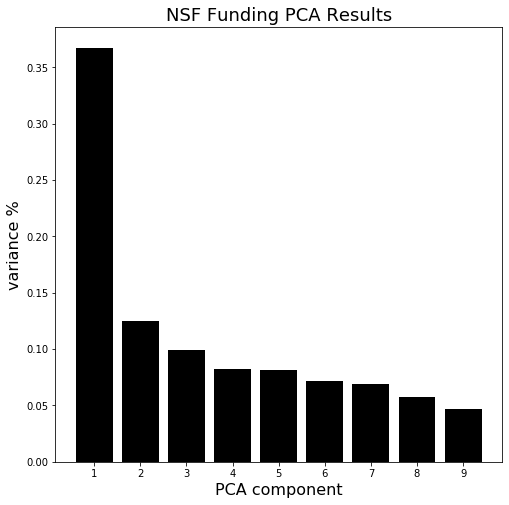

In [11]:
# Plot the explained variances
features = range(1,pca.n_components_+1)
plt.figure(figsize=(8,8))
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.title("NSF Funding PCA Results", fontsize=18)
plt.xlabel('PCA component', fontsize=16)
plt.ylabel('variance %', fontsize=16)
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

Text(0, 0.5, 'PCA Component #2')

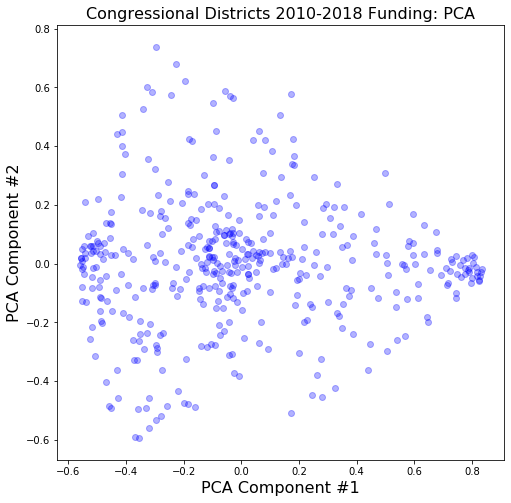

In [12]:
#Now plot how our CD funding data using the first 2 PCA components
plt.figure(figsize=(8,8))
plt.title("Congressional Districts 2010-2018 Funding: PCA", fontsize=16)
plt.scatter(PCA_components[0], PCA_components[1], alpha=.3, color='blue')
plt.xlabel('PCA Component #1',fontsize=16)
plt.ylabel('PCA Component #2',fontsize=16)

In [13]:
# This function performs KMeans using the input data and number of clusters
def get_kmeans_labels(input_data, n_clusters):
    km = KMeans(random_state = 2019, n_clusters = n_clusters)
    km.fit(input_data)
    res = km.predict(input_data)
    return res

# This function performs Gaussian Mixture using the input data and number of clusters
def get_gaussian_labels(input_data, n_clusters):
    gmm = GaussianMixture(n_components = n_clusters, covariance_type='full' ,random_state = 1993)
    gmm.fit(input_data)
    res = gmm.predict(input_data)
    return res

# This function runs a clustering algorithm and finds the cluster number (and cluster labels)
#  with the best silhouette score for a specified range of clusters
def find_best_cluster(max_clusters, input_data, labels_func):
    best_cluster = 0
    best_avg = -1
    best_labels = []
    for n_clusters in range(2, max_clusters+1):
        cluster_labels = labels_func(input_data, n_clusters)
        silhouette_avg = silhouette_score(input_data, cluster_labels)
        if silhouette_avg >= best_avg:
            best_avg = silhouette_avg
            best_cluster = n_clusters
            best_labels = cluster_labels
    return {'cluster_num': best_cluster, 'labels': best_labels, 'score': best_avg}

# This function simply prints the number of iterms in each cluster
def describe_labels(labels, score, title):
    if score:
        print(title+" Clusters: {}, Score: {}".format(len(np.unique(labels)), score))
    else: 
        print(title+" Clusters: {}".format(len(np.unique(labels))))
    for cluster in np.unique(labels):
        print("Cluster {}, Size: {}".format(cluster, (labels == cluster).sum()))
    print()


In [14]:
## These functions are used for visualizing our data results

#This function plots (line) the mean and error per each cluster 
def visualize_avgs(input_data, labels, title=None):
    plt.figure(figsize=(8,8))
    if title:
        plt.title(title,fontsize=16)
    for cluster in np.unique(labels):
        if cluster == -1:
            continue
        temp = input_data[labels == cluster].mean(axis=0)
        std  = input_data[labels == cluster].std(axis=0)
        plt.plot(range(2010,2019), temp, label = str(cluster),
                 color=['orange','g', 'r','b', 'c', 'm', 'y', 'k','b'][cluster%7])
        plt.errorbar(range(2010,2019), temp, yerr=std, fmt='o', capsize=10,
                     color=['orange','g', 'r','b', 'c', 'm', 'y', 'k','b'][cluster%7])
    legend_vals = list(np.unique(labels))
    if -1 in legend_vals: legend_vals.remove(-1)
    plt.legend(legend_vals, title='Cluster#')
    plt.xlabel('Fiscal Year',fontsize=16)
    plt.ylabel('Mean Funding Received (Normalized)',fontsize=16)
    plt.show() 
    
#This function just plots our PCA results but with cluster labels
def visualize_pca(pca_data, labels, title=None):
    plt.figure(figsize=(8,8))
    if title:
        plt.title(title,fontsize=16)
    for i in np.unique(labels):    
        tmp = PCA_components[ labels == i]
        plt.scatter(tmp[0], tmp[1], alpha=.4, color=['orange','g', 'r', 'c', 'm', 'y', 'k', 'b'][i%7])
    plt.legend(np.unique(labels), title='Cluster#')
    plt.xlabel('PCA component 1',fontsize=16)
    plt.ylabel('PCA component 2',fontsize=16)
    plt.show() 

#This function bar plots mean/error of our data per each cluster per category 
def bar_plot_results(ax, results, labels, title):
    N = len(np.unique(labels))
    ind = np.arange(len(results.columns))  # the x locations for the groups
    width = 0.2       # the width of the bars

    labels_unique = np.unique(labels)
    mean_g = []
    std_g = []
    for cluster in np.unique(labels):
        
        tmp = results[labels == cluster]    
        tmp_mean = tmp.mean()  
        tmp_std = tmp.std()
        
        mean_g.append(list(tmp_mean))
        std_g.append(list(tmp_std))

    rects = []
    for idx in range(len(mean_g)):
        rect = ax.bar(ind+(width*idx), mean_g[idx], width,  capsize=10, yerr=std_g[idx],
                      color=['orange','g', 'r', 'c', 'm', 'y', 'k', 'b'][idx%7]) 
        rects.append(rect)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Category', fontsize=16)
    ax.set_ylabel('Percentage', fontsize=16)
    ax.set_xticks(ind+width)
    ax.set_xticklabels( results.columns )
    ax.legend( [item for item in rects], np.unique(labels), title='Cluster #' )

KMeans Clusters: 2, Score: 0.2710228591380176
Cluster 0, Size: 130
Cluster 1, Size: 304



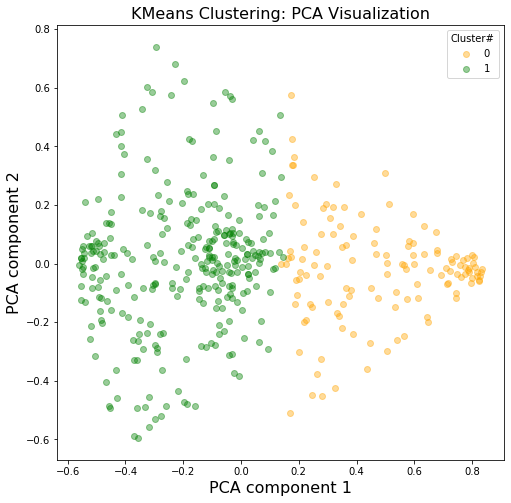

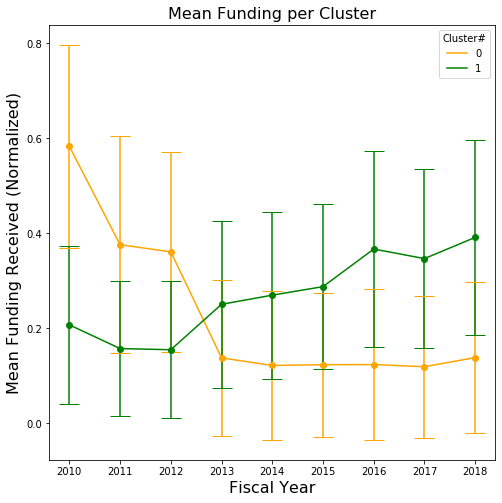

In [15]:
# Now we will use some helper functions to find the best KMeans model for our data
kmean_cluster_info = find_best_cluster(10, nsf_funding_norm, get_kmeans_labels)
describe_labels(kmean_cluster_info['labels'], kmean_cluster_info['score'], "KMeans")

labels_kmeans = kmean_cluster_info['labels']
visualize_pca(PCA_components, labels_kmeans, "KMeans Clustering: PCA Visualization")
visualize_avgs(nsf_funding_norm, labels_kmeans, "Mean Funding per Cluster")

In [16]:
#Next we add the congressional density index data 
cd_descriptive = nsf_funding.merge(citylab_data, how='inner', left_on="CD", right_on ='CD')
#And also we add the party counts for the years 2010-2018 to each CD entry 
cd_descriptive = cd_descriptive.merge(party_counts, how='inner', left_on="CD", right_on ='CD')
#We did this to be able to do our descriptive analysis on each cluster

print(len(cd_descriptive), "records")
cd_descriptive.head()

434 records


,CD,2010,2011,2012,2013,2014,2015,2016,2017,2018,Very low density,Low density,Medium density,High density,Pre-2018 incumbent,Pre-2018 party,2018 winner party,Clinton16,Trump16,Obama12,Romney12,Obama08,McCain08,cong_R16,cong_D16,cong_Other16,PVI,Pure rural,Rural-suburban mix,Sparse suburban,Dense suburban,Urban-suburban mix,Pure urban,Rural,Suburban,Urban,Democratic,Republican,Other,Total
0,AK-AL,51603573.00000,22687709.00000,22539453.00000,18967382.00000,20995436.00000,13296918.00000,14825962.00000,25180562.00000,28372191.00000,0.48299,0.19833,0.22925,0.08943,Don Young,R,R,0.37600,0.52800,0.41200,0.55300,0.38100,0.59700,0.50321,0.36022,0.13657,9,0.42453,0.36823,0.08579,0.06039,0.04274,0.01832,0.79276,0.14618,0.06106,0.00000,1.00000,0.00000,9
1,AL-01,1491436.00000,2094388.00000,812058.00000,2951772.00000,2258434.00000,2580521.00000,1620257.00000,2424339.00000,2815529.00000,0.36536,0.42888,0.19741,0.00835,Bradley Byrne,R,R,0.34100,0.63500,0.37400,0.61800,0.38500,0.60900,0.96382,0.00000,0.03618,15,0.05286,0.87889,0.04258,0.01370,0.00834,0.00362,0.93175,0.05628,0.01197,0.00000,1.00000,0.00000,8
2,AL-02,191663.00000,698822.00000,1664756.00000,0.00000,1564887.00000,737822.00000,475136.00000,2286960.00000,1124906.00000,0.53549,0.31615,0.14837,0.00000,Martha Roby,R,R,0.33000,0.64900,0.36400,0.62900,0.35000,0.64500,0.48769,0.40526,0.10705,16,0.84647,0.11375,0.01845,0.01024,0.00740,0.00371,0.96022,0.02868,0.01110,0.11111,0.88889,0.00000,9
3,AL-03,11416358.00000,17828995.00000,5335738.00000,8842962.00000,7510531.00000,5526549.00000,16313640.00000,13572790.00000,14050883.00000,0.54041,0.38935,0.06555,0.00469,Mike Rogers,R,R,0.32300,0.65300,0.36800,0.62300,0.36600,0.62600,0.66932,0.32932,0.00136,16,0.74623,0.17631,0.03582,0.01890,0.01473,0.00801,0.92254,0.05472,0.02274,0.00000,1.00000,0.00000,9
4,AL-04,1713314.00000,0.00000,0.00000,1037202.00000,179999.00000,795529.00000,0.00000,0.00000,0.00000,0.69533,0.28894,0.01573,0.00000,Robert Aderholt,R,R,0.17400,0.80400,0.24000,0.74800,0.25500,0.73300,0.98530,0.00000,0.01470,30,0.80989,0.10235,0.03396,0.02260,0.01930,0.01190,0.91224,0.05656,0.03120,0.00000,1.00000,0.00000,9


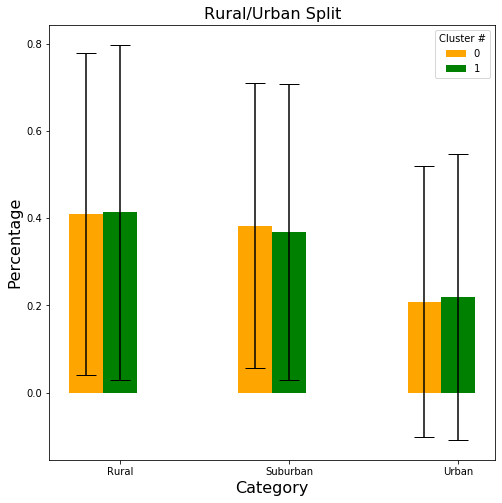

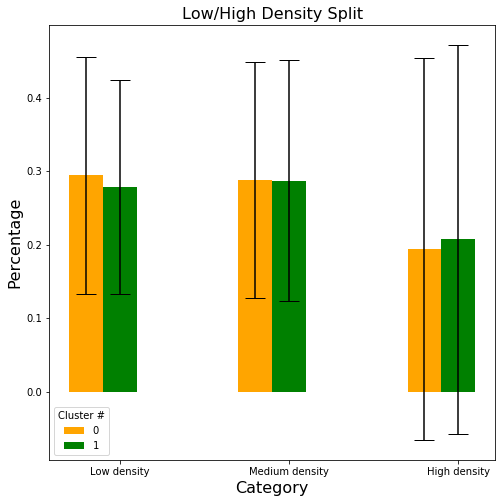

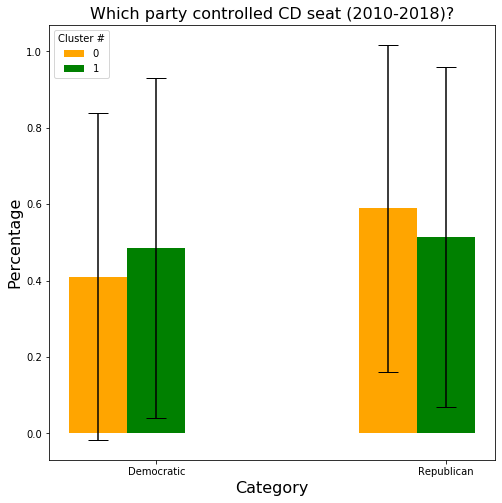

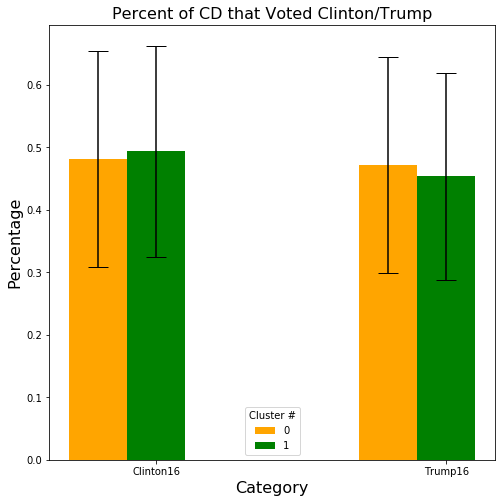

In [17]:
# Now we will plot how each cluster compares in terms of urbanization, density, and political lean
fig, axis = plt.subplots(1, 1, figsize=(8,8))
bar_plot_results(axis, cd_descriptive.loc[:,'Rural':'Urban'], labels_kmeans, "Rural/Urban Split")
fig, axis = plt.subplots(1, 1, figsize=(8,8))
bar_plot_results(axis, cd_descriptive.loc[:,'Low density':'High density'], labels_kmeans, "Low/High Density Split")
fig, axis = plt.subplots(1, 1, figsize=(8,8))
bar_plot_results(axis, cd_descriptive.loc[:,'Democratic':'Republican'], labels_kmeans, "Which party controlled CD seat (2010-2018)?")
fig, axis = plt.subplots(1, 1, figsize=(8,8))
bar_plot_results(axis, cd_descriptive.loc[:,'Clinton16':'Trump16'], labels_kmeans, "Percent of CD that Voted Clinton/Trump")
plt.show()

Finally we took our clustered data and visualized how each congressional district was clusted on a map of the continental united states

In [18]:
# We need to translate from full state name to its acronym to be able to match the data
states = {
    'AK': 'Alaska','AL': 'Alabama','AR': 'Arkansas','AS': 'American Samoa','AZ': 'Arizona','CA': 'California',
    'CO': 'Colorado','CT': 'Connecticut','DC': 'District Of Columbia','DE': 'Delaware','FL': 'Florida','GA': 'Georgia',
    'GU': 'Guam','HI': 'Hawaii','IA': 'Iowa','ID': 'Idaho','IL': 'Illinois','IN': 'Indiana','KS': 'Kansas','KY': 'Kentucky',
    'LA': 'Louisiana','MA': 'Massachusetts','MD': 'Maryland','ME': 'Maine','MI': 'Michigan','MN': 'Minnesota','MO': 'Missouri',
    'MP': 'Northern Mariana Islands','MS': 'Mississippi','MT': 'Montana','NA': 'National','NC': 'North Carolina',
    'ND': 'North Dakota','NE': 'Nebraska','NH': 'New Hampshire','NJ': 'New Jersey','NM': 'New Mexico','NV': 'Nevada',
    'NY': 'New York','OH': 'Ohio','OK': 'Oklahoma','OR': 'Oregon','PA': 'Pennsylvania','PR': 'Puerto Rico',
    'RI': 'Rhode Island','SC': 'South Carolina','SD': 'South Dakota','TN': 'Tennessee','TX': 'Texas','UT': 'Utah',
    'VA': 'Virginia','VI': 'Virgin Islands','VT': 'Vermont','WA': 'Washington','WI': 'Wisconsin','WV': 'West Virginia',
    'WY': 'Wyoming'
}
state_name_map = {v: k for k, v in states.items()}

In [19]:
# From http://cdmaps.polisci.ucla.edu/
districts_map = geopandas.read_file("zip://./data/districts114.zip!districtShapes/districts114.shp")
districts_map.sort_values(by=['STATENAME'], inplace=True)
districts_map.head()

,STATENAME,ID,DISTRICT,STARTCONG,ENDCONG,DISTRICTSI,COUNTY,PAGE,LAW,NOTE,BESTDEC,FINALNOTE,RNOTE,LASTCHANGE,FROMCOUNTY,geometry
257,Alabama,001113114002,2,113,114,None,None,None,None,None,None,"{""From US Census website""}",None,2016-05-29 16:44:10.857626,F,"POLYGON ((-87.427516 31.26273999999999, -87.42..."
256,Alabama,001113114001,1,113,114,None,None,None,None,None,None,"{""From US Census website""}",None,2016-05-29 16:44:10.857626,F,(POLYGON ((-88.46442951455998 31.6979519844040...
150,Alabama,001113114003,3,113,114,None,None,None,None,None,None,"{""From US Census website""}",None,2016-05-29 16:44:10.857626,F,"POLYGON ((-86.577798 33.76651999999999, -86.57..."
151,Alabama,001113114004,4,113,114,None,None,None,None,None,None,"{""From US Census website""}",None,2016-05-29 16:44:10.857626,F,POLYGON ((-88.27458799999999 33.53424999999996...
152,Alabama,001113114005,5,113,114,None,None,None,None,None,None,"{""From US Census website""}",None,2016-05-29 16:44:10.857626,F,POLYGON ((-88.20295899264993 35.00802799988243...


In [20]:
# We also add a new CD row that matches ours in format 
def to_cd(row):
    if row['DISTRICT'] == 0 or int(row['DISTRICT']) == 0:
        return state_name_map[row["STATENAME"]] + "-" +"AL"
    else:
        return state_name_map[row["STATENAME"]] + "-" + "{:02d}".format(int(row['DISTRICT']))

districts_map["CD"] = districts_map.apply(to_cd, axis=1)

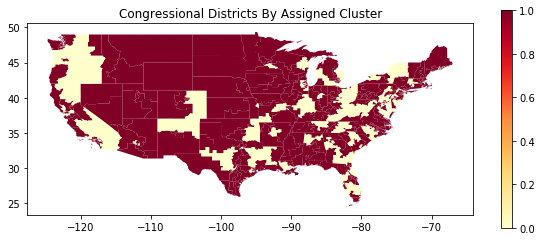

In [21]:
# Finally we plot each cluster onto a map of the united states
cd_descriptive['cluster'] = labels_kmeans
districts_labeled = districts_map.merge(cd_descriptive[['CD', 'cluster']], how='inner', left_on="CD", right_on ='CD')

fig, ax = plt.subplots(1, figsize=(10,4))
ax.set_title("Congressional Districts By Assigned Cluster")
districts_labeled[~districts_labeled['STATENAME'].isin(['Alaska', 'Hawaii'])] \
    .plot(ax=ax, column='cluster', cmap="YlOrRd", legend=True)

Below is code that was not used but could be repurposed for Gaussian Mix or DBSCAN

In [22]:
## CODE FOR IF WE HAD ALSO INCLUDED GAUSSIAN MIX AND DBSCAN

# gauss_cluster_info = find_best_cluster(10, nsf_funding_norm, get_gaussian_labels)
# describe_labels(gauss_cluster_info['labels'], gauss_cluster_info['score'], "Gaussian")

# labels_gaus = gauss_cluster_info['labels']
# visualize_pca(PCA_components, labels_gaus, "Gaussian Mixture: PCA Visualization")
# visualize_avgs(nsf_funding_norm, labels_gaus, "Gaussian Mixture Cluster Avg Funding Received")

# dbscan = DBSCAN(eps=.25, min_samples=20).fit(nsf_funding_norm)
# labels_dbscan = dbscan.labels_

# describe_labels(labels_dbscan, None, "DBSCAN")
# visualize_pca(PCA_components, labels_dbscan, "DBSCAN Clustering: PCA Visualization (-1 == Noise)")
# visualize_avgs(nsf_funding_norm, labels_dbscan, "DBSCAN Cluster Avg Funding Received")

## CODE IF WE HAD ALSO DONE GAUSSIAN AND DBSCAN

# fig, axis = plt.subplots(2, 2, figsize=(25,25))
# bar_plot_results(axis[0][0], cd_descriptive.loc[:,'Pure rural':'Pure urban'], labels_dbscan, "Rural/Urban Split")
# bar_plot_results(axis[0][1], cd_descriptive.loc[:,'Low density':'High density'], labels_dbscan, "Low/Highg Density Split")
# bar_plot_results(axis[1][0], cd_descriptive.loc[:,'Democratic':'Republican'], labels_dbscan, "Which party is on the CD seat (2010-2018)?")
# bar_plot_results(axis[1][1], cd_descriptive.loc[:,'Clinton16':'Trump16'], labels_dbscan, "Percent that Voted Clinton/Trump")
# plt.show()

# fig, axis = plt.subplots(1, 2, figsize=(25,10))
# bar_plot_results(axis[0], cd_descriptive.loc[:,'Pure rural':'Pure urban'], labels_gaus, "Rural/Urban Split")
# bar_plot_results(axis[1], cd_descriptive.loc[:,'Low density':'High density'], labels_gaus, "Low/High Density Split")
# fig, axis = plt.subplots(1, 2, figsize=(25,10))
# bar_plot_results(axis[0], cd_descriptive.loc[:,'Democratic':'Republican'], labels_gaus, "Which party is on the CD seat (2010-2018)?")
# bar_plot_results(axis[1], cd_descriptive.loc[:,'Clinton16':'Trump16'], labels_gaus, "Percent that Voted Clinton/Trump")
# plt.show()

## CODE FOR VISUALIZING ON MAP GAUSSIAN MIX AND DBSCAN CLUSTERING RESULTS

# cd_descriptive['cluster'] = labels_gaus
# districts_labeled = districts.merge(cd_descriptive[['CD', 'cluster']], how='inner', left_on="CD", right_on ='CD')
# fig, ax = plt.subplots(1, 1, figsize=(15, 10))
# ax.set_title("Gaussian Mixture Clustering")
# districts_labeled[~districts_labeled['STATENAME'].isin(['Alaska', 'Hawaii'])] \
#     .plot(ax=ax, column='cluster', legend=True)

# cd_descriptive['cluster'] = labels_dbscan
# districts_labeled = districts.merge(cd_descriptive[['CD', 'cluster']], how='inner', left_on="CD", right_on ='CD')
# fig, ax = plt.subplots(1, 1, figsize=(15, 10))
# ax.set_title("DBSCAN Clustering")
# districts_labeled[~districts_labeled['STATENAME'].isin(['Alaska', 'Hawaii'])] \
#     .plot(ax=ax, column='cluster', legend=True)